# Fully Convolutional Watershed Distance Transform for 2D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [8]:
import os
import errno

import numpy as np

import sys
sys.path.insert(0,"/home/snn/deepcell-tf")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import deepcell

ImportError: No module named 'deepcell.utils.compute_overlap'

In [2]:
import math
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from tensorflow.python.keras.utils.data_utils import get_file

from deepcell import losses
import image_gen as image_gen
from deepcell import image_generators
from deepcell import model_zoo
from deepcell.layers import TensorProduct, ReflectionPadding2D, DilatedMaxPool2D

from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.training import train_model_conv


from tensorflow.python.keras.layers import MaxPool2D
from conv_gru_layer import ConvGRU2D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.python.keras.layers import Conv2D, ZeroPadding2D, ConvLSTM2D, Cropping2D
from tensorflow.python.keras.layers import Input, Add, Concatenate, Flatten, Reshape
from tensorflow.python.keras.engine.input_layer import InputLayer

from tensorflow.python.keras.models import Model


from tensorflow.python.keras.regularizers import l2
from deepcell.layers import ImageNormalization2D, ImageNormalization3D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Softmax

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

ImportError: No module named 'deepcell.utils.compute_overlap'

### Load the Training Data

from deepcell.utils.tracking_utils import load_trks

DATA_DIR = '/data/npz_data/tracking_benchmark_data'
DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_V1.trks')

trks = load_trks(DATA_FILE)
np.savez(os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_V1.npz'), X=trks['X'], y=trks['y'])

In [3]:
# If DATA_FILE exists just run this cell

from deepcell.utils.data_utils import get_data

DATA_DIR = '/data/npz_data/tracking_benchmark_data'
DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_V1.npz')

# Load Information for hardcoded image size training
seed = 1
test_size = .2
train_dict, test_dict = get_data(DATA_FILE, seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

 -
X.shape: (4000, 216, 256, 1)
y.shape: (4000, 216, 256, 1)


### Set up filepath constants

In [2]:
# Set up other required filepaths
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)
ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

NameError: name 'DATA_FILE' is not defined

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [26]:
def feature_net_3D(receptive_field=61,
                    n_frames=3,
                    input_shape=(5, 256, 256, 1),
                    n_features=3,
                    n_channels=1,
                    reg=1e-5,
                    n_conv_filters=64,
                    n_dense_filters=200,
                    gru_kernel_size =3,
                    VGG_mode=False,
                    init='he_normal',
                    norm_method='whole_image',
                    gru=False,
                    location=False,
                    dilated=False,
                    padding=False,
                    padding_mode='reflect',
                    multires=False,
                    include_top=True):
    # Create layers list (x) to store all of the layers.
    # We need to use the functional API to enable the multiresolution mode
    x = []

    win = (receptive_field - 1) // 2
    win_z = (n_frames - 1) // 2

    if dilated:
        padding = True

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        time_axis = 2
        row_axis = 3
        col_axis = 4
        if not dilated:
            input_shape = (n_channels, n_frames, receptive_field, receptive_field)
    else:
        channel_axis = -1
        time_axis = 1
        row_axis = 2
        col_axis = 3
        if not dilated:
            input_shape = (n_frames, receptive_field, receptive_field, n_channels)

    x.append(Input(shape=input_shape))
    x.append(ImageNormalization3D(norm_method=norm_method, filter_size=receptive_field)(x[-1]))

    if padding:
        if padding_mode == 'reflect':
            x.append(ReflectionPadding3D(padding=(win_z, win, win))(x[-1]))
        elif padding_mode == 'zero':
            x.append(ZeroPadding3D(padding=(win_z, win, win))([-1]))

    if location:
        x.append(Location3D(in_shape=tuple(x[-1].shape.as_list()[1:]))(x[-1]))
        x.append(Concatenate(axis=channel_axis)([x[-2], x[-1]]))

    if multires:
        layers_to_concat = []

    rf_counter = receptive_field
    block_counter = 0
    d = 1

    append_gru = False
    while rf_counter > 4:
        filter_size = 3 if rf_counter % 2 == 0 else 4
        if append_gru == True:
            x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=(filter_size, filter_size), dilation_rate=(d, d),
                            padding='valid', kernel_initializer=init,
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        else:
            x.append(Conv3D(n_conv_filters, (1, filter_size, filter_size), 
                            dilation_rate=(1, d, d), kernel_initializer=init,
                            padding='valid', kernel_regularizer=l2(reg))(x[-1]))

        
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))

        block_counter += 1
        rf_counter -= filter_size - 1

        if block_counter % 2 == 0:
            if dilated:
                x.append(DilatedMaxPool3D(dilation_rate=(1, d, d), pool_size=(1, 2, 2))(x[-1]))
                d *= 2
            else:
                x.append(MaxPool3D(pool_size=(1, 2, 2))(x[-1]))

            if VGG_mode:
                n_conv_filters *= 2

            rf_counter = rf_counter // 2

            if multires:
                layers_to_concat.append(len(x) - 1)

    if multires:
        c = []
        for l in layers_to_concat:
            output_shape = x[l].get_shape().as_list()
            target_shape = x[-1].get_shape().as_list()
            time_crop = (0, 0)

            row_crop = int(output_shape[row_axis] - target_shape[row_axis])

            if row_crop % 2 == 0:
                row_crop = (row_crop // 2, row_crop // 2)
            else:
                row_crop = (row_crop // 2, row_crop // 2 + 1)

            col_crop = int(output_shape[col_axis] - target_shape[col_axis])

            if col_crop % 2 == 0:
                col_crop = (col_crop // 2, col_crop // 2)
            else:
                col_crop = (col_crop // 2, col_crop // 2 + 1)

            cropping = (time_crop, row_crop, col_crop)

            c.append(Cropping3D(cropping=cropping)(x[l]))
        x.append(Concatenate(axis=channel_axis)(c))
        
    
    x.append(Conv3D(n_dense_filters, (1, rf_counter, rf_counter), dilation_rate=(1, d, d), kernel_initializer=init, padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(Conv3D(n_dense_filters, (n_frames, 1, 1), dilation_rate=(1, d, d), kernel_initializer=init, padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))
    
    if gru == True:
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=(gru_kernel_size, gru_kernel_size),
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        # x.append(Activation('relu')(x[-1]))
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=(gru_kernel_size +2, gru_kernel_size +2),
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        # x.append(Activation('relu')(x[-1]))
    
    
    x.append(TensorProduct(n_dense_filters, kernel_initializer=init, kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(TensorProduct(n_features, kernel_initializer=init, kernel_regularizer=l2(reg))(x[-1]))

    if not dilated:
        x.append(Flatten()(x[-1]))

    if include_top:
        x.append(Softmax(axis=channel_axis)(x[-1]))

    model = Model(inputs=x[0], outputs=x[-1])
    model.summary()

    return model

In [27]:
from tensorflow.python.keras.layers import Lambda;

def image_norm(inputs):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    axes = [3, 4] if channel_axis == 1 else [2, 3]
    output = inputs - K.mean(inputs, axis=axes, keepdims=True)
    output = output / K.std(inputs, axis=axes, keepdims=True)
    return output

def feature_net_skip_3D(receptive_field=61,
                        input_shape=(5, 256, 256, 1),
                        fgbg_model=None,
                        gru=False,
                        gru_kernel_size=3,
                        last_only=True,
                        n_skips=1,
                        norm_method='whole_image',
                        padding_mode='reflect',
                        **kwargs):
    # print(K.image_data_format())
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    inputs = Input(shape=input_shape)
    
    img = Lambda(image_norm)(inputs)
    #img = BatchNormalization(axis=channel_axis)(inputs)

    models = []
    model_outputs = []

    if fgbg_model is not None:
        for layer in fgbg_model.layers:
            layer.trainable = False
        models.append(fgbg_model)
        fgbg_output = fgbg_model(inputs)
        if isinstance(fgbg_output, list):
            fgbg_output = fgbg_output[-1]
        model_outputs.append(fgbg_output)

    for _ in range(n_skips + 1):
        if model_outputs:
            model_input = Concatenate(axis=channel_axis)([img, model_outputs[-1]])
        else:
            model_input = img
        new_input_shape = model_input.get_shape().as_list()[1:]
        models.append(feature_net_3D(receptive_field=receptive_field, 
                                     input_shape=new_input_shape, norm_method=None, dilated=True, 
                                     padding=True, padding_mode=padding_mode, gru=gru, 
                                     gru_kernel_size=gru_kernel_size, **kwargs))
        model_outputs.append(models[-1](model_input))

    if last_only:
        model = Model(inputs=inputs, outputs=model_outputs[-1])
    else:
        if fgbg_model is None:
            model = Model(inputs=inputs, outputs=model_outputs)
        else:
            model = Model(inputs=inputs, outputs=model_outputs[1:])
    model.summary()
    return model

#### (1) Function to create the model fgbg model

In [1]:
def create_and_train_fgbg(lr_sched, train_dict, test_dict, fgbg_gru_model_name, gru_kernel_size=3, gru=False):
    
    fgbg_model = feature_net_skip_3D(
                    n_features=2,  # segmentation mask (is_cell, is_not_cell)
                    receptive_field=receptive_field,
                    n_skips=n_skips,
                    n_conv_filters=32,
                    n_dense_filters=128,
                    gru=gru,
                    gru_kernel_size=gru_kernel_size,
                    input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
                    last_only=False)

    print("Training fgbg model. \n")

    fgbg_model = train_model_conv(
        model=fgbg_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=fgbg_gru_model_name,
        log_dir=LOG_DIR,
        transform='fgbg',
        optimizer=optimizer,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

    # Save model
    fgbg_gru_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_gru_model_name))
    fgbg_model.save_weights(fgbg_gru_weights_file)

    return fgbg_model

### Next, Create a model for the watershed energy transform

### Function to create the distance transform model

In [2]:
def create_and_train_gru(lr_sched, train_dict, test_dict, conv_gru_model_name, gru_kernel_size=3, gru=False):
    
    conv_gru_model = feature_net_skip_3D(
        receptive_field=receptive_field,
        n_skips=n_skips,
        n_features=4,  # (background edge, interior edge, cell interior, background)
        n_frames=frames_per_batch,
        n_conv_filters=32,
        n_dense_filters=128,
        gru=gru,
        gru_kernel_size=gru_kernel_size,
        multires=False,
        last_only=False,
        input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[1:])),
        norm_method=norm_method)

    print("Training segmentation model. \n")

    conv_gru_model = train_model_conv(
        model=conv_gru_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=conv_gru_model_name,
        log_dir=LOG_DIR,
        optimizer=optimizer,
        transform='watershed', #'deepcell_flat', 
        dilation_radius=dilation_radius,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))
    
    # Save model
    conv_gru_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_gru_model_name))
    conv_gru_model.save_weights(conv_gru_weights_file)

# Train the models

### Training settings

In [30]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'trackingSEG_conv_gru_fgbg_model'
conv_model_name = 'trackingSEG_conv_gru_watershed_model'

n_epoch = 10  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch
frames_per_batch = 1

# Transformation settings
transform = 'watershed'
distance_bins = 4
erosion_width = 1  # erode edges

### (1) Train fgbg model

In [31]:
fgbg_model =  create_and_train_fgbg(lr_sched, train_dict, test_dict, fgbg_model_name, gru_kernel_size=3, gru=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 216, 256, 1)       0         
_________________________________________________________________
image_normalization2d_5 (Ima (None, 216, 256, 1)       3721      
_________________________________________________________________
reflection_padding2d_2 (Refl (None, 276, 316, 1)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 273, 313, 32)      544       
_________________________________________________________________
batch_normalization_16 (Batc (None, 273, 313, 32)      128       
_________________________________________________________________
activation_16 (Activation)   (None, 273, 313, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 271, 311, 32)      9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 216, 256, 3)       0         
_________________________________________________________________
image_normalization2d_7 (Ima (None, 216, 256, 3)       11163     
_________________________________________________________________
reflection_padding2d_4 (Refl (None, 276, 316, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 273, 313, 32)      1568      
_________________________________________________________________
batch_normalization_32 (Batc (None, 273, 313, 32)      128       
_________________________________________________________________
activation_32 (Activation)   (None, 273, 313, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 271, 311, 32)      9248      
__________

Training fgbg model. 

X_train shape: (4000, 216, 256, 1)
y_train shape: (4000, 216, 256, 1)
X_test shape: (1000, 216, 256, 1)
y_test shape: (1000, 216, 256, 1)
Output Shape: (None, 216, 256, 2)
Number of Classes: 2
Training on 2 GPUs
Epoch 1/10
1999/2000 [============================>.] - ETA: 0s - loss: nan - model_2_loss: 0.0095 - model_3_loss: 0.0819 - model_4_loss: 1.3592 - model_5_loss: 0.1647 - model_2_acc: 0.9145 - model_3_acc: 0.9145 - model_4_acc: 0.7102 - model_5_acc: 0.9675
Epoch 00001: val_loss did not improve from inf
2000/2000 [==============================] - 1485s 743ms/step - loss: nan - model_2_loss: 0.0095 - model_3_loss: 0.0818 - model_4_loss: 1.3592 - model_5_loss: 0.1647 - model_2_acc: 0.9146 - model_3_acc: 0.9145 - model_4_acc: 0.7103 - model_5_acc: 0.9675 - val_loss: nan - val_model_2_loss: 2.3268e-07 - val_model_3_loss: 2.3268e-07 - val_model_4_loss: 15.3422 - val_model_5_loss: 0.6322 - val_model_2_acc: 0.9163 - val_model_3_acc: 0.9163 - val_model_4_acc: 0.91

In [32]:
watershed_model =  create_and_train_fgbg(lr_sched, train_dict, test_dict, conv_model_name, gru_kernel_size=3, gru=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 216, 256, 1)       0         
_________________________________________________________________
image_normalization2d_10 (Im (None, 216, 256, 1)       3721      
_________________________________________________________________
reflection_padding2d_6 (Refl (None, 276, 316, 1)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 273, 313, 32)      544       
_________________________________________________________________
batch_normalization_48 (Batc (None, 273, 313, 32)      128       
_________________________________________________________________
activation_48 (Activation)   (None, 273, 313, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 271, 311, 32)      9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 216, 256, 3)       0         
_________________________________________________________________
image_normalization2d_12 (Im (None, 216, 256, 3)       11163     
_________________________________________________________________
reflection_padding2d_8 (Refl (None, 276, 316, 3)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 273, 313, 32)      1568      
_________________________________________________________________
batch_normalization_64 (Batc (None, 273, 313, 32)      128       
_________________________________________________________________
activation_64 (Activation)   (None, 273, 313, 32)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 271, 311, 32)      9248      
__________

Training fgbg model. 

X_train shape: (4000, 216, 256, 1)
y_train shape: (4000, 216, 256, 1)
X_test shape: (1000, 216, 256, 1)
y_test shape: (1000, 216, 256, 1)
Output Shape: (None, 216, 256, 2)
Number of Classes: 2
Training on 2 GPUs
Epoch 1/10
1999/2000 [============================>.] - ETA: 0s - loss: nan - model_8_loss: 0.0020 - model_9_loss: 0.1062 - model_10_loss: 1.3567 - model_11_loss: 0.1599 - model_8_acc: 0.9147 - model_9_acc: 0.9148 - model_10_acc: 0.7573 - model_11_acc: 0.9689
Epoch 00001: val_loss did not improve from inf
2000/2000 [==============================] - 1483s 742ms/step - loss: nan - model_8_loss: 0.0020 - model_9_loss: 0.1062 - model_10_loss: 1.3568 - model_11_loss: 0.1598 - model_8_acc: 0.9148 - model_9_acc: 0.9148 - model_10_acc: 0.7574 - model_11_acc: 0.9689 - val_loss: nan - val_model_8_loss: 2.3268e-07 - val_model_9_loss: 2.3268e-07 - val_model_10_loss: 16.1179 - val_model_11_loss: 1.0769 - val_model_8_acc: 0.9163 - val_model_9_acc: 0.9163 - val_model_1

### Run the model

#### Make predictions on test data

In [33]:
# make predictions on testing data
test_images = watershed_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1000, 216, 256, 2)
segmentation mask shape: (1000, 216, 256, 2)


### Watershed post-processing

In [34]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (1000, 216, 256, 1)


In [35]:
# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [36]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)

### Plot the Results

Image number: 194


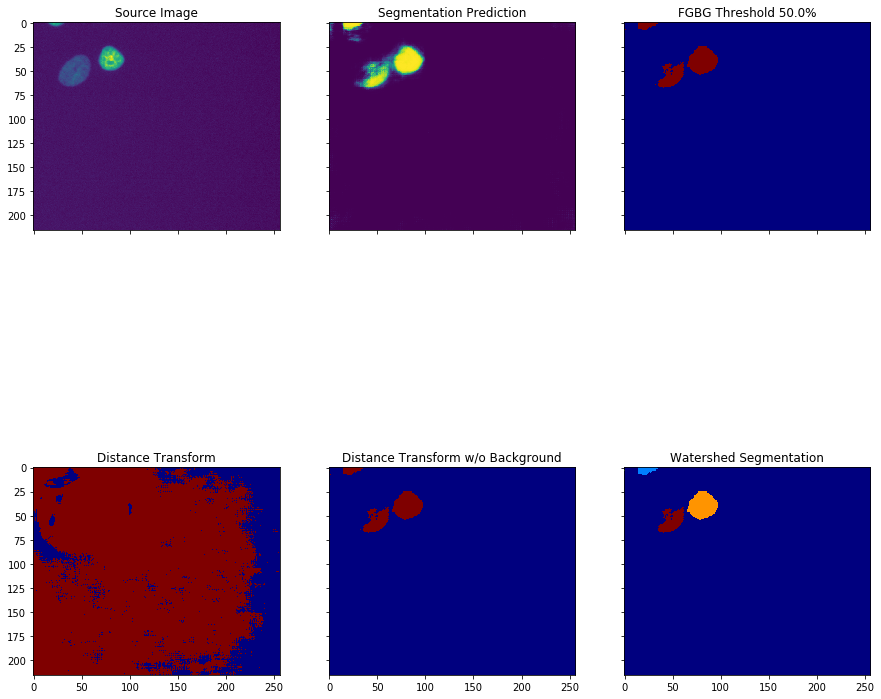

<Figure size 432x288 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(argmax_images[index, ..., 0], cmap='jet')
ax[3].set_title('Distance Transform')

ax[4].imshow(argmax_images_post_fgbg[index, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform w/o Background')

ax[5].imshow(watershed_images[index, ..., 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

# fig.tight_layout()
plt.show()
plt.savefig('test.png')

### Run the Model Iteratively

In [60]:
# Define the Datasets

###### For Deepcell Datasets

# Define data to load (raw images from trk test files)
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa, raw_trks_RAW]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [62]:
# Instantiate new models for any image size

from deepcell import model_zoo

fgbg_model = feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    gru=True,
    gru_kernel_size=3,
    input_shape=(None, None, 1),
    last_only=False)

fgbg_model.load_weights('models/trackingSEG_conv_fgbg_model.h5')


watershed_model = feature_net_skip_2D(
        fgbg_model=fgbg_model,
        receptive_field=receptive_field,
        n_skips=n_skips,
        n_features=distance_bins,  # (background edge, interior edge, cell interior, background)
        n_conv_filters=32,
        n_dense_filters=128,
        gru=True,
        gru_kernel_size=3,
        last_only=False,
        input_shape=(None, None, 1))

watershed_model.load_weights('models/trackingSEG_conv_watershed_model.h5')

ValueError: Tried to convert 'shape' to a tensor and failed. Error: None values not supported.

In [13]:
# Make predictions on test data

from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics

from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max


CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa', 'RAW264']

# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.5

Lstats_AllDatasets = []

# Go through each Dataset (3T3, HEK293, HeLa, RAW264.7)
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    lineages, raw, tracked = trks['lineages'], trks['X'], trks['y']
    
    # Create an array for the new annotations
    y_new = np.zeros(tracked.shape)
        
    Lstats = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):
        # Predict on the raw data
        test_images = watershed_model.predict(movie)[-1]
        test_images_fgbg = fgbg_model.predict(movie)[-1]

        # Postprocessing
        # Collapse predictions into semantic segmentation mask
        argmax_images = []
        for i in range(test_images.shape[0]):
            max_image = np.argmax(test_images[i], axis=-1)
            argmax_images.append(max_image)
        argmax_images = np.array(argmax_images)
        argmax_images = np.expand_dims(argmax_images, axis=-1)
        
        # threshold the foreground/background
        # and remove background from watershed transform
        fg_thresh = test_images_fgbg[..., 1] > threshold

        fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
        argmax_images_post_fgbg = argmax_images * fg_thresh
        
        # Apply watershed method with the distance transform as seed
        watershed_images = []
        for i in range(argmax_images_post_fgbg.shape[0]):
            image = fg_thresh[i, ..., 0]
            distance = argmax_images_post_fgbg[i, ..., 0]

            local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)

            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)
            watershed_images.append(segments)

        watershed_images = np.array(watershed_images)
        watershed_images = np.expand_dims(watershed_images, axis=-1)
        
        
        # Accuracy from metrics package
        
        filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
        
        # Remove small objects from GT for comparison
        small_objects_threshold=100        
        GT_image = remove_small_objects(tracked[batch_num, :, :, :, :].astype('uint16'), min_size=small_objects_threshold)
        #GT_image = tracked[batch_num, :, :, :, :].astype('uint16')
        
        m = metrics.Metrics(model_name = filename)
        m.calc_object_stats(GT_image, watershed_images)
        #m.save_to_json(m.output)    
        Lstats.append(m.stats)
                
    Lstats_AllDatasets.append(Lstats)
    
    
df_3T3    = pd.concat(Lstats_AllDatasets[0]) 
df_HEK293 = pd.concat(Lstats_AllDatasets[1])
df_HeLa   = pd.concat(Lstats_AllDatasets[2])
df_RAW264 = pd.concat(Lstats_AllDatasets[3])

    


INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 339
Number of predicted cells:	 354

Correct detections:  296	Recall: 87.315634218289090995313017629086971282958984375%
Incorrect detections: 58	Precision: 83.6158192090395431250726687721908092498779296875%

Gained detections: 57	Perc Error: 57.5757575757575779107355629093945026397705078125%
Missed detections: 41	Perc Error: 41.4141414141414117011663620360195636749267578125%
Merges: 1		Perc Error: 1.0101010101010101660534701295546256005764007568359375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79094946143461519749706667425925843417644500732421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 194
Number

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 332
Number of predicted cells:	 378

Correct detections:  315	Recall: 94.87951807228915868108742870390415191650390625%
Incorrect detections: 63	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 63	Perc Error: 78.75%
Missed detections: 17	Perc Error: 21.25%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85628838799149120664111478617996908724308013916015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 276
Number of predicted cells:	 340

Correct detections:  158	Recall: 57.2463768115942031045051408000290393829345703125%
Incorrect detections: 182	Preci

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 406
Number of predicted cells:	 418

Correct detections:  342	Recall: 84.2364532019704483900568448007106781005859375%
Incorrect detections: 76	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 18	Perc Error: 22.5%
Missed detections: 32	Perc Error: 40%
Merges: 2		Perc Error: 2.5%
Splits: 28		Perc Error: 35%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 28
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79442620077511161280625628933194093406200408935546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 247
Number of predicted cells:	 252

Correct detections:  196	Recall: 79.3522267206477778245243825949728488922119140625%
Incorrect detections: 56	Precisio

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 424
Number of predicted cells:	 319

Correct detections:  262	Recall: 61.7924528301886795134123531170189380645751953125%
Incorrect detections: 57	Precision: 82.131661442006276274696574546396732330322265625%

Gained detections: 19	Perc Error: 12.6666666666666660745477201999165117740631103515625%
Missed detections: 99	Perc Error: 66%
Merges: 27		Perc Error: 18%
Splits: 1		Perc Error: 0.66666666666666662965923251249478198587894439697265625%
Catastrophes: 4		Perc Error: 2.666666666666666518636930049979127943515777587890625%

Gained detections from splits: 1
Missed detections from merges: 27
True detections involved in catastrophes: 8
Predicted detections involved in catastrophes: 9 

Average Pixel IOU (Jaccard Index): 0.82447548177374041511455970976385287940502166748046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 540
Number of predicted cells:	 493

Correct detections:  447	Recall: 82.77777777777777146184234879910945892333984375%
Incorrect detections: 46	Precision: 90.6693711967545681318370043300092220306396484375%

Gained detections: 8	Perc Error: 12.6984126984126977077949049999006092548370361328125%
Missed detections: 17	Perc Error: 26.984126984126984183376407600007951259613037109375%
Merges: 38		Perc Error: 60.3174603174603163324718479998409748077392578125%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 38
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8028190303160414043048831445048563182353973388671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 585
Number 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 354
Number of predicted cells:	 346

Correct detections:  315	Recall: 88.983050847457633381054620258510112762451171875%
Incorrect detections: 31	Precision: 91.040462427745666218470432795584201812744140625%

Gained detections: 31	Perc Error: 44.28571428571428469922466319985687732696533203125%
Missed detections: 39	Perc Error: 55.71428571428571530077533680014312267303466796875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84378911381525301127481952789821662008762359619140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 496
Number of predicted cells:	 505

Correct detections:  455	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 282
Number of predicted cells:	 282

Correct detections:  282	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8593979526270043578506374615244567394256591796875 



/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:779: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['gained_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:782: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['missed_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:785: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['merge'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:788: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['split'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:791: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['catastrophe'].sum() / total_e

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 125
Number of predicted cells:	 114

Correct detections:  71	Recall: 56.7999999999999971578290569595992565155029296875%
Incorrect detections: 43	Precision: 62.28070175438596578487704391591250896453857421875%

Gained detections: 43	Perc Error: 44.3298969072164936733315698802471160888671875%
Missed detections: 54	Perc Error: 55.6701030927835063266684301197528839111328125%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70305538698297109778678759539616294205188751220703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 169
Number of predicted cells:	 178

Correct detections:  169	Recall

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 190
Number of predicted cells:	 186

Correct detections:  153	Recall: 80.5263157894736849584660376422107219696044921875%
Incorrect detections: 33	Precision: 82.2580645161290391342845396138727664947509765625%

Gained detections: 25	Perc Error: 46.29629629629629761211617733351886272430419921875%
Missed detections: 21	Perc Error: 38.888888888888885730921174399554729461669921875%
Merges: 8		Perc Error: 14.8148148148148148806058088666759431362152099609375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 8
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8288030545986246888645609942614100873470306396484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 205
Number o

In [14]:
CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa, df_RAW264]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)



3T3


Correct Detections:  5956
Incorrect Detections:  1593
Splits:  84
Merges:  30
Catastrophes:  0
Recall:  85.15870746354018
Precision:  78.8978672671877
Average Jaccard Index:  0.7856856660656756


HEK293


Correct Detections:  11136
Incorrect Detections:  1506
Splits:  116
Merges:  469
Catastrophes:  18
Recall:  78.93393819109725
Precision:  88.08732795443758
Average Jaccard Index:  0.7983899369881121


HeLa


Correct Detections:  5236
Incorrect Detections:  637
Splits:  1
Merges:  20
Catastrophes:  0
Recall:  89.88841201716738
Precision:  89.15375446960668
Average Jaccard Index:  0.8338876022177726


RAW264


Correct Detections:  4246
Incorrect Detections:  405
Splits:  0
Merges:  44
Catastrophes:  0
Recall:  88.58752347172961
Precision:  91.29219522683294
Average Jaccard Index:  0.8016708828790599


### Make Predictions on ISBI Data for Metrics

In [6]:
###### FOR ISBI Challenge Datasets

# Define data to load (raw images from trk test files)  
RAW_BASE_DIR = '/data/data/ISBI_Tracking_Challenge/tracks'

raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'ISBI_HeLa_Chal_GT.trks')
raw_trks_MSC  = os.path.join(RAW_BASE_DIR, 'ISBI_MSC_resized_Chal_GT_normalized.trks')
raw_trks_U373 = os.path.join(RAW_BASE_DIR, 'ISBI_U373_Chal_GT.trks')

#raw_trks_files = [raw_trks_HeLa, raw_trks_MSC, raw_trks_U373]
raw_trks_files = [raw_trks_HeLa]

# Define where segmentations will be saved
SEG_BASE_DIR = '/data/track_data/Final_Benchmarks/ISBI_DC_SEG/Watershed/HeLa_segmentations'
                             
DC_seg_HeLa  = os.path.join(SEG_BASE_DIR, 'HeLa/')
DC_seg_MSC   = os.path.join(SEG_BASE_DIR, 'MSC/')
DC_seg_U373  = os.path.join(SEG_BASE_DIR, 'U373/')

#DC_seg_folders = [DC_seg_HeLa, DC_seg_MSC, DC_seg_U373]
DC_seg_folders = [DC_seg_HeLa]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [5]:
# Instantiate new models for any image size

from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=(None, None, 1),
    last_only=False)

fgbg_model.load_weights('/data/models/trackingSEG_conv_fgbg_model.h5')


watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=(None, None, 1))

watershed_model.load_weights('/data/models/trackingSEG_conv_watershed_model.h5')

In [ ]:
# Run Predict for metric information only

CELL_TYPE_NAME = ['HeLa']
threshold = 0.9

from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import tarfile
import pathlib
import tempfile
import json
import pandas as pd
from io import BytesIO


def load_trks(filename):
    """Load a trk/trks file.

    Args:
        trks_file: full path to the file including .trk/.trks

    Returns:
        A dictionary with raw, tracked, and lineage data
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

    return {'X': raw, 'y': tracked}


Lstats_AllDatasets = []

# Go through each Dataset
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    raw, tracked = trks['X'], trks['y']
    
    # Create an array for the new annotations
    y_new = np.zeros(tracked.shape)
                
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):

        Lstats = []
        # Predict on the raw data
        for frame_num, frame in enumerate(movie):
            
            image = np.expand_dims(frame, axis=0)
             
            test_image = watershed_model.predict(image)[-1]
            test_image_fgbg = fgbg_model.predict(image)[-1]

            # Postprocessing
            # Collapse predictions into semantic segmentation mask        
            max_image = np.argmax(test_image, axis=-1)
            argmax_image = np.expand_dims(max_image, axis=-1)
        
            # threshold the foreground/background
            # and remove background from watershed transform
            fg_thresh = test_image_fgbg[..., 1] > threshold

            fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
            argmax_image_post_fgbg = argmax_image * fg_thresh
        
            # Apply watershed method with the distance transform as seed
            image = fg_thresh[..., 0]
            distance = argmax_image_post_fgbg[..., 0]

            local_maxi = peak_local_max(test_image[..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)

            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)
            watershed_image = np.expand_dims(segments, axis=-1)
            
            # Remove small objects from GT for comparison
            small_objects_threshold=50
            GT_image = trks['y'][batch_num, frame_num, :, :, :]
            GT_image = np.expand_dims(GT_image, axis=0)
            GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)
            
            # Accuracy from metrics package
            filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
            
            m = metrics.Metrics(model_name = filename)
            m.calc_object_stats(GT_image, watershed_image)
            
            # Store results
            y_new[batch_num, frame_num, :, :, :] = watershed_image

            Lstats.append(m.stats)
            
    # Save results of this batch before moving on to the next
    filename = os.path.join(DC_seg_folders[set_num], 'all_batches.trks')
    filename = pathlib.Path(filename)

    with tarfile.open(str(filename), 'w') as trks:
        with tempfile.NamedTemporaryFile() as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            trks.add(raw_file.name, 'raw.npy')

        with tempfile.NamedTemporaryFile() as tracked_file:
            np.save(tracked_file, y_new)
            tracked_file.flush()
            trks.add(tracked_file.name, 'tracked.npy')
                
        
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)
    
    
#df_HeLa   = pd.concat(Lstats_AllDatasets[0])
df_HeLa = pd.concat([pd.concat(Lstats_AllDatasets[0][0]) , pd.concat(Lstats_AllDatasets[0][1])])


INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 65
Number of predicted cells:	 63

Correct detections:  59	Recall: 90.76923076923077360333991236984729766845703125%
Incorrect detections: 4	Precision: 93.650793650793644928853609599173069000244140625%

Gained detections: 4	Perc Error: 40%
Missed detections: 6	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.728796067936541280829487732262350618839263916015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 65
Number of predicted cells:	 63

Correct detections:  58	Recall: 89.23076923076922639666008763015270233154296875%
Incorrect detections: 5	Precision: 92.0634920634920

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 81
Number of predicted cells:	 75

Correct detections:  69	Recall: 85.185185185185190448464709334075450897216796875%
Incorrect detections: 6	Precision: 92%

Gained detections: 6	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 12	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.733945912081027440621028290479443967342376708984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 82
Number of predicted cells:	 76

Correct detections:  71	Recall: 86.5853658536585299998478149063885211944580078125

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 103
Number of predicted cells:	 98

Correct detections:  90	Recall: 87.378640776699029402152518741786479949951171875%
Incorrect detections: 8	Precision: 91.8367346938775455100767430849373340606689453125%

Gained detections: 6	Perc Error: 31.578947368421051322684434126131236553192138671875%
Missed detections: 12	Perc Error: 63.15789473684210264536886825226247310638427734375%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 5.26315789473684247923301882110536098480224609375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.72856336210373473516455078424769453704357147216796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 105
Number of pr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 121
Number of predicted cells:	 116

Correct detections:  113	Recall: 93.388429752066116407149820588529109954833984375%
Incorrect detections: 3	Precision: 97.4137931034482704717447631992399692535400390625%

Gained detections: 3	Perc Error: 27.27272727272727337322066887281835079193115234375%
Missed detections: 8	Perc Error: 72.7272727272727337322066887281835079193115234375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.72824455217387151773067444082698784768581390380859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 123
Number of predicted cells:	 117

Correct detections:  113	Rec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 140
Number of predicted cells:	 138

Correct detections:  127	Recall: 90.7142857142857081953479791991412639617919921875%
Incorrect detections: 11	Precision: 92.0289855072463751639588735997676849365234375%

Gained detections: 11	Perc Error: 45.83333333333333570180911920033395290374755859375%
Missed detections: 13	Perc Error: 54.16666666666666429819088079966604709625244140625%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75680027406646110943455596498097293078899383544921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 146
Number of predicted cells:	 139

Correct detections:  128	R

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 161
Number of predicted cells:	 156

Correct detections:  153	Recall: 95.031055900621112186854588799178600311279296875%
Incorrect detections: 3	Precision: 98.0769230769230802025049342773854732513427734375%

Gained detections: 3	Perc Error: 27.27272727272727337322066887281835079193115234375%
Missed detections: 8	Perc Error: 72.7272727272727337322066887281835079193115234375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.760189390566093692314098007045686244964599609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 162
Number of predicted cells:	 160

Correct detections:  154	Recall: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 193
Number of predicted cells:	 189

Correct detections:  180	Recall: 93.2642487046632169267468270845711231231689453125%
Incorrect detections: 9	Precision: 95.23809523809524080206756480038166046142578125%

Gained detections: 9	Perc Error: 40.909090909090906507117324508726596832275390625%
Missed detections: 13	Perc Error: 59.090909090909093492882675491273403167724609375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7594108444606006980137635764549486339092254638671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 195
Number of predicted cells:	 190

Correct detections:  186	Recall:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 214
Number of predicted cells:	 205

Correct detections:  198	Recall: 92.5233644859813040284279850311577320098876953125%
Incorrect detections: 7	Precision: 96.5853658536585299998478149063885211944580078125%

Gained detections: 6	Perc Error: 28.571428571428572951163005200214684009552001953125%
Missed detections: 14	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 1		Perc Error: 4.76190476190476186246769429999403655529022216796875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7746123878363395665047619331744499504566192626953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 214
Number o

In [10]:
CELL_TYPE_DF = [df_HeLa]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)



HeLa


Correct Detections:  29941
Incorrect Detections:  1134
Splits:  21
Merges:  121
Catastrophes:  3
Recall:  94.24892974061949
Precision:  96.35076427996782
Average Jaccard Index:  0.7919377398470048
